### Grid World Environment

In [1]:
class GridWorld_Env:
    def __init__(self, hor, ver):
        self.actions = ["left", "up", "right", "down"] # 0=Left, 1=Up, 2=right, 3=Down 
        self.x = 0
        self.y = 0
        self.MAX_HOR_VAL = hor-1
        self.MAX_VER_VAL = ver-1
        self.done = False
        self.episode_length = 0
        self.no_operation = False
        self.state_observation = [self.x, self.y]
        
    def reset(self):
        self.done = False
        self.episode_length = 0
        self.x, self.y = 0, 0
        self.state_observation = [self.x, self.y]
        return [self.x, self.y]
    
    def action_space(self):
        return self.actions
  
    def step(self, action):
        if self.state_observation == [self.MAX_HOR_VAL, self.MAX_VER_VAL]:
            self.done = True
            self.no_operation = False
            return np.array(self.state_observation), self.reward, self.done, self.no_operation, self.episode_length
        elif self.episode_length > 200:
            self.done = True
            self.no_operation = True
            return np.array(self.state_observation), self.reward, self.done, self.no_operation, self.episode_length
        
        self.action = action
        self.reward = self.get_reward()
        self.state_observation = self.take_action()
        self.episode_length += 1
        self.no_operation = False
        
        if(self.episode_length >= 200):
            self.done = True
        
        return np.array(self.state_observation), self.reward, self.done, self.no_operation, self.episode_length
    
    def get_reward(self):
        '''
        Return value : rewards
        Input argument. 
        '''
        if (self.x == 0 and self.action == "left") or (self.x == self.MAX_HOR_VAL and self.action == "right"):
            return -2
        elif (self.y == 0 and self.action == "down") or (self.y == self.MAX_VER_VAL and self.action == "up"):
            return -2
        elif (self.x, self.y) == (self.MAX_HOR_VAL-1, self.MAX_VER_VAL) and self.action == "right":
            return 0
        elif (self.x, self.y) == (self.MAX_HOR_VAL, self.MAX_VER_VAL-1) and self.action == "up":
            return 0
        else:
            return -1
    
    def take_action(self):
#         # Check Errors
#         if self.x < 0 or self.y < 0 or self.x > self.MAX_HOR_VAL or self.y > self.MAX_VER_VAL:
#             print("Error in getting the state. Please execute the reset() function")
#             return (np.inf*-1)
                
        if self.x > -1 and self.x <= self.MAX_HOR_VAL:
            if (self.action == "left" and self.x == 0) or (self.action == "right" and self.x == self.MAX_HOR_VAL):
                self.x = self.x
            elif(self.action == "left"):
                self.x -= 1
            elif(self.action == "right"):
                self.x += 1
            else:
                self.x = self.x
                
        if self.y > -1 and self.y <= self.MAX_VER_VAL:
            if (self.action == "down" and self.y == 0) or (self.action == "up" and self.y == self.MAX_HOR_VAL):
                self.y = self.y
            elif(self.action == "down"):
                self.y -= 1
            elif(self.action == "up"):
                self.y += 1
            else:
                self.y = self.y
                        
        return [self.x, self.y]
    

### Code for the agent to test environment

In [2]:
'''Functions for the agent'''
def best_state_action_value(current_state):
    max_val = np.inf*-1
#     from IPython.core.debugger import Tracer; Tracer()() 
    for key in current_state.keys():
        if current_state[key] > max_val:
            max_val = current_state[key]
            best_action = key
    return best_action, max_val

def current_state_to_string(state):
    current_state = ''.join(str(int(e)) for e in state)
    return current_state

def get_all_states_as_strings():
    states = []
    for i in range(MAX_HOR_LENGTH):
        for j in range(MAX_VER_LENGTH):
            tmp = [i,j]
            states.append("".join(str(a) for a in tmp))
    return states

def initialize_Q():
    Q = {}
    states = get_all_states_as_strings()
    for state in states:
        Q[state] = {}
        for i in range(4): #Number of actions = 4
            Q[state][i] = np.random.uniform(-2,2,1)
    return Q


In [3]:
import numpy as np
import pandas as pd

MAX_HOR_LENGTH = 4
MAX_VER_LENGTH = 4
MAX_STATES = MAX_HOR_LENGTH*MAX_HOR_LENGTH
TOTAL_EPISODES = 1000
SIM_RUN = 10
SHOW_EVERY = 10
OBSERVATION_SPACE = 2
LEARNING_RATE = 0.05 # alpha in the literature
DISCOUNT = 0.95 # gamma IN the literature
EPSILON = 0.1
START_EPSILON_DECAYING = 150
END_EPSILON_DECAYING = 600
epsilon_decay_value = EPSILON/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

Summed_reward = []

for sim in range(SIM_RUN):
    EPSILON = 0.1 
    done = False
    
    agent = GridWorld_Env(MAX_HOR_LENGTH, MAX_VER_LENGTH)
    Q_table = initialize_Q() 

    Total_running_reward = []
    action_space = agent.action_space()
    action_indexes = [i for i in range(len(action_space))]
    cnt = 0
    no_op = False
    for episode in range(TOTAL_EPISODES):
        done = False
        current_state = agent.reset()
        cnt += 1
        total_episode_reward = 0
        episode_length = 0

        while not done:
            current_state_str = current_state_to_string(current_state)
            kind_of_selection_ = 'None'

            if np.random.uniform() > EPSILON:
                action, max_qt1 = best_state_action_value(Q_table[current_state_str])
                kind_of_selection_ = 'Greedy'
            else:
                action = np.random.choice(action_indexes)
                max_qt1 = Q_table[current_state_str][action]
                kind_of_selection_ = 'Random'

            next_state, reward, done, no_op, episode_length = agent.step(action_space[action])
            total_episode_reward += reward
            Q_table[current_state_str][action] += LEARNING_RATE*(reward + DISCOUNT*max_qt1 - Q_table[current_state_str][action])
#             print(f'current state : {current_state}. Action : {action_space[action]}. Next state: {next_state}. Kind of Sel: {kind_of_selection_}')
            current_state = next_state;
            cnt+=1

        Total_running_reward.append(total_episode_reward)
        
        if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
            EPSILON -= epsilon_decay_value
    
    if sim == 0:
        Summed_reward = Total_running_reward
    else: 
        Summed_reward = np.vstack((Summed_reward,Total_running_reward))
        
    if sim % SHOW_EVERY == 0:
        print(sim)

# Displaying average reward

df = pd.DataFrame(Summed_reward)
Mean_total_reward = df.mean()
Mean_total_reward
# print('--------------------------')
# print(f'Numer of steps per episode : {episode_length}. Reward : {Total_running_reward}')

0


0     -156.7
1     -136.8
2      -79.7
3      -37.2
4      -40.0
       ...  
995    -20.0
996    -27.0
997    -22.8
998    -22.4
999    -21.8
Length: 1000, dtype: float64

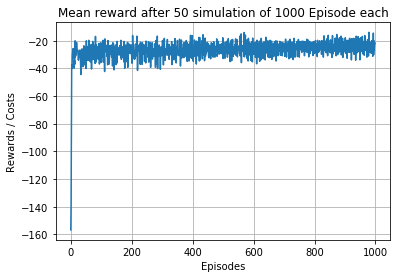

In [6]:
import matplotlib.pyplot as plt

plt.plot(Mean_total_reward)
plt.grid()
plt.title('Mean reward after 50 simulation of 1000 Episode each')
plt.xlabel('Episodes')
plt.ylabel('Rewards / Costs')
plt.show()

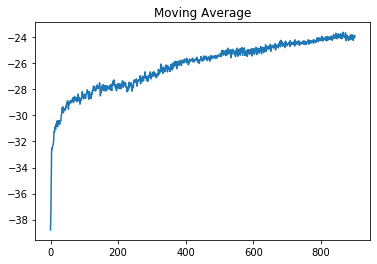

In [5]:
# Moving average
N = 100
cumsum, moving_aves = [0], []

for i, x in enumerate(Total_running_reward, 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
        #can do stuff with moving_ave here
        moving_aves.append(moving_ave)

plt.plot(moving_aves)
plt.title('Moving Average')
plt.show()